In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

2023-06-05 17:25:01.881790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-05 17:25:01.881811: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-05 17:25:05.206329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-05 17:25:05.206349: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-05 17:25:05.206365: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (amir-asus): /proc/driver/nvidia/version does not exist
2023-06-05 17:25:05.206558: I tensorflow/core/platform/cpu_feature_

### Define function to create scalable hard to sim circuit.

In [3]:
def create_circuit(n_qubits):
    circuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(n_qubits)
    for i in range(n_qubits):
        symbol = sympy.Symbol("Y" + '-' + str(i))
        circuit.append(cirq.Y(qubits[i])**symbol)
    for i in range(n_qubits):
        symbol = sympy.Symbol("XX"+"-"+str(i))
        circuit.append(cirq.XX(qubits[i], qubits[(i+1)%n_qubits])**symbol)
    measurements = []
    for i in range(1):
        measurements.append(cirq.Z(qubits[i]))
    
    return circuit, measurements

test function

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


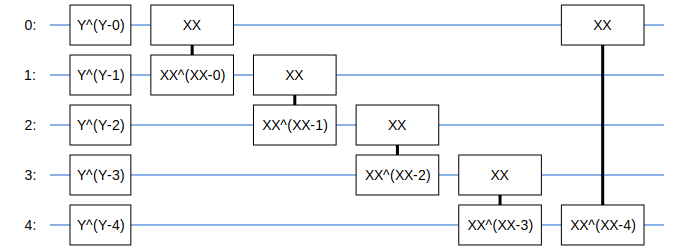

In [4]:

n_qubits = 5
circuit, measurements = create_circuit(n_qubits)

SVGCircuit(circuit)

In [5]:
quantum_layer = tfq.layers.PQC(circuit, measurements)
quantum_data = tfq.convert_to_tensor([
    cirq.Circuit()
])

quantum_layer(quantum_data)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.85098875]], dtype=float32)>

In [6]:
# making tfq model out of it

model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(circuit, measurements),
])

In [7]:
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

In [8]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_1 (PQC)                 (None, 1)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
model(quantum_data)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.2674712]], dtype=float32)>

In [11]:
model.fit(quantum_data, y=np.ones((1, 1)), 
          epochs=200,
          verbose=1,)

Epoch 1/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0127
Epoch 2/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 3/200
1/1 [==============================] - 0s 2ms/step - loss: 2.3992e-04
Epoch 4/200
1/1 [==============================] - 0s 3ms/step - loss: 2.5993e-06
Epoch 5/200
1/1 [==============================] - 0s 3ms/step - loss: 7.8837e-06
Epoch 6/200
1/1 [==============================] - 0s 3ms/step - loss: 1.8910e-04
Epoch 7/200
1/1 [==============================] - 0s 3ms/step - loss: 9.1992e-04
Epoch 8/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 9/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 10/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0066
Epoch 11/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 12/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 13/200
1/1 [=======================

## Real tests

In [12]:
steps = 200
file_name="tensorflow.csv"

In [13]:
import time

def test_time(n_qubits):
    circuit, measurements = create_circuit(n_qubits)

    model = tf.keras.Sequential([
        # The input is the data-circuit, encoded as a tf.string
        tf.keras.layers.Input(shape=(), dtype=tf.string),
        # The PQC layer returns the expected value of the readout gate, range [-1,1].
        tfq.layers.PQC(circuit, measurements),
    ])
    
    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam())
    beg_steps = 5
    
    model.fit(quantum_data, y=np.ones((1, 1)), 
            epochs=beg_steps,
            batch_size=1,
            verbose=0,)
    
    beg = time.time()
    model.fit(quantum_data, y=np.ones((1, 1)), 
            epochs=steps,
            batch_size=1,
            verbose=0,)
    end = time.time()
    return (end-beg)*1000

In [20]:
from bench_func import run_benchmark

run_benchmark(range(2, 22), test_time, file_name)

  0%|          | 0/20 [00:00<?, ?it/s]

[2, 230.19003868103027]
[3, 288.4855270385742]
[4, 346.32396697998047]
[5, 361.38081550598145]
[6, 738.184928894043]
[7, 464.7631645202637]
[8, 488.71493339538574]
[9, 566.6563510894775]
[10, 624.0267753601074]
[11, 878.9622783660889]
[12, 1166.6758060455322]
[13, 1593.5547351837158]
[14, 2247.666597366333]
[15, 2767.6446437835693]
[16, 2171.9164848327637]
[17, 2726.3832092285156]
[18, 4971.135854721069]
[19, 9725.886106491089]
[20, 43203.009843826294]
[21, 129091.09115600586]
